In [6]:
import numpy as np
from qiskit.quantum_info import Statevector, Operator, SparsePauliOp
from qiskit.circuit.library import PauliEvolutionGate
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator

# --- 1. Define System Parameters ---
# These are example values. You should use the specific values from your problem.
E_C = 1.0   # Charging energy (e.g., in GHz, or arbitrary energy units)
E_J = 10.0  # Josephson energy
hbar = 1.0  # Set hbar = 1 for simplicity in calculations (energy units are implied)

# Derived parameters
omega_1 = np.sqrt(8 * E_C * E_J) / hbar # Plasma frequency for site 1
omega_2 = np.sqrt(8 * E_C * E_J) / hbar # Plasma frequency for site 2
K_1 = E_C   # Anharmonicity for site 1 (from doc: alpha = E_C)
K_2 = E_C   # Anharmonicity for site 2
J = 0.5 * E_J # Josephson tunneling amplitude (adjust as needed, related to E_J)

# Number of qubits
num_qubits_per_site = 2 # 2 qubits for 3 bosonic levels (0, 1, 2)
num_qubits_ancilla = 1
total_qubits = 2 * num_qubits_per_site + num_qubits_ancilla # 5 qubits

# Define qubit indices for clarity (LSB...MSB for string representation):
# Site 1: qubits 0, 1 (q0=LSB of site 1, q1=MSB of site 1)
# Site 2: qubits 2, 3 (q2=LSB of site 2, q3=MSB of site 2)
# Ancilla: qubit 4

# --- 2. Helper Functions for Single Site Operators (Matrices) ---
# Maps bosonic states (0, 1, 2) to 2-qubit computational basis states (|00>, |01>, |10>)
# The unused state is |11>

def _get_site_op_matrix(op_type):
    """
    Returns the 4x4 matrix for a single site's bosonic operator.
    op_type can be 'n' (number), 'anharmonicity', 'b' (annihilation), 'b_dagger' (creation).
    Assumes Np=3 levels (0, 1, 2 bosons) mapped to |00>, |01>, |10>.
    """
    matrix = np.zeros((4, 4), dtype=complex)

    # Qubit basis mapping:
    # |00> corresponds to 0 bosons
    # |01> corresponds to 1 boson
    # |10> corresponds to 2 bosons
    # |11> is unused/forbidden

    if op_type == 'n': # Number operator n = |1><1| + 2|2><2|
        matrix[1, 1] = 1  # 1 boson state |01>
        matrix[2, 2] = 2  # 2 boson state |10>
    elif op_type == 'anharmonicity': # |2><2| (from the document's 2|2><2| for H term)
        matrix[2, 2] = 1  # Corresponds to 2 bosons state |10>
    elif op_type == 'b': # Annihilation operator b
        # b|1> = 1|0>  => matrix[index(|00>), index(|01>)] = 1
        matrix[0, 1] = 1
        # b|2> = sqrt(2)|1> => matrix[index(|01>), index(|10>)] = sqrt(2)
        matrix[1, 2] = np.sqrt(2)
    elif op_type == 'b_dagger': # Creation operator b_dagger
        # b_dagger|0> = 1|1> => matrix[index(|01>), index(|00>)] = 1
        matrix[1, 0] = 1
        # b_dagger|1> = sqrt(2)|2> => matrix[index(|10>), index(|01>)] = sqrt(2)
        matrix[2, 1] = np.sqrt(2)
    else:
        raise ValueError(f"Unknown op_type: {op_type}")
    return matrix

# Helper to expand a SparsePauliOp from a subsystem to the full system
def expand_op_to_full_system(sub_op: SparsePauliOp, sub_qubits: list, total_qubits: int):
    """
    Expands a SparsePauliOp defined on a subsystem to the full system by
    inserting 'I's on non-acting qubits.
    sub_qubits must be sorted in increasing order for correct mapping.
    """
    full_op_list = []
    # Qiskit's Pauli string ordering is LSB (rightmost) to MSB (leftmost) for SparsePauliOp.from_label()
    # str(Pauli) reverses this.
    
    for i in range(len(sub_op.paulis)):
        pauli_label = str(sub_op.paulis[i]) # This gives MSB...LSB string
        coeff = sub_op.coeffs[i]
        
        # Create a list of 'I's for the full system
        full_pauli_chars = ['I'] * total_qubits
        
        # Place the sub-operator's Pauli characters at the correct positions
        # Iterate over the sub_qubits to place the characters from the sub_op's Pauli label
        # pauli_label is MSB...LSB, so we iterate from end for LSB...MSB for insertion.
        # Example: sub_qubits = [0, 1] (q0, q1)
        # pauli_label 'ZI' for Z on q1, I on q0
        # str(pauli_label) is 'ZI'
        # Reversed: 'IZ'
        # q0 gets 'I', q1 gets 'Z'
        
        # Correctly map characters from pauli_label (MSB..LSB) to full_pauli_chars (LSB..MSB)
        for k in range(len(pauli_label)):
            # pauli_label[k] is the char for the (k)th qubit from MSB (left)
            # Its corresponding qubit index in the sub-system is (len(pauli_label) - 1 - k) for LSB.
            # Then map that to the full system's qubit index.
            sub_q_idx_lsb_order = len(pauli_label) - 1 - k
            
            # This is the actual qubit index in the full system where this Pauli char goes
            full_q_idx = sub_qubits[sub_q_idx_lsb_order]
            
            # Place the char from pauli_label (read LSB to MSB)
            full_pauli_chars[full_q_idx] = pauli_label[k]
        
        # Convert to LSB...MSB string for SparsePauliOp.from_label
        full_pauli_string_lsb_msb = "".join(full_pauli_chars)
        full_op_list.append((full_pauli_string_lsb_msb, coeff))

    return SparsePauliOp.from_list(full_op_list)

# --- 3. Construct the Full Hamiltonian as SparsePauliOp ---
full_hamiltonian = SparsePauliOp('I' * total_qubits, 0) # Initialize with zero operator

# On-site energy terms (hbar*omega_i * n_i)
n_op_s_sub = SparsePauliOp.from_operator(Operator(_get_site_op_matrix('n')))
full_hamiltonian += omega_1 * expand_op_to_full_system(n_op_s_sub, [0, 1], total_qubits)
full_hamiltonian += omega_2 * expand_op_to_full_system(n_op_s_sub, [2, 3], total_qubits)

# Anharmonicity terms (-K_i * |2><2|_i)
anharm_op_s_sub = SparsePauliOp.from_operator(Operator(_get_site_op_matrix('anharmonicity')))
full_hamiltonian += -K_1 * expand_op_to_full_system(anharm_op_s_sub, [0, 1], total_qubits)
full_hamiltonian += -K_2 * expand_op_to_full_system(anharm_op_s_sub, [2, 3], total_qubits)

# Tunneling Term: $-J(\overline{b}_{1}^{\dagger}\overline{b}_{2}+\overline{b}_{2}^{\dagger}\overline{b}_{1})$
b_op_s_sub = SparsePauliOp.from_operator(Operator(_get_site_op_matrix('b')))
b_dagger_op_s_sub = SparsePauliOp.from_operator(Operator(_get_site_op_matrix('b_dagger')))

# Term 1: b_dagger_1 @ b_2
# This involves multiplying operators acting on different qubit registers.
# If op1 acts on [q_a, q_b] and op2 acts on [q_c, q_d], their product is a tensor product.
# We build this by iterating through their Pauli terms and forming combined Pauli strings.
b1_dag_paulis = b_dagger_op_s_sub.paulis
b1_dag_coeffs = b_dagger_op_s_sub.coeffs
b2_paulis = b_op_s_sub.paulis
b2_coeffs = b_op_s_sub.coeffs

for i in range(len(b1_dag_paulis)):
    for j in range(len(b2_paulis)):
        # Get Pauli labels for sub-operators (MSB...LSB order from str(Pauli))
        pauli_label_s1 = str(b1_dag_paulis[i])
        pauli_label_s2 = str(b2_paulis[j])
        
        combined_coeff = b1_dag_coeffs[i] * b2_coeffs[j]
        
        full_pauli_chars = ['I'] * total_qubits
        
        # Map Pauli characters from site 1 to its qubits [0,1]
        # pauli_label_s1 is MSB...LSB. LSB char is at index len-1, MSB char at index 0.
        full_pauli_chars[0] = pauli_label_s1[len(pauli_label_s1)-1] # LSB of site 1
        full_pauli_chars[1] = pauli_label_s1[len(pauli_label_s1)-2] # MSB of site 1

        # Map Pauli characters from site 2 to its qubits [2,3]
        full_pauli_chars[2] = pauli_label_s2[len(pauli_label_s2)-1] # LSB of site 2
        full_pauli_chars[3] = pauli_label_s2[len(pauli_label_s2)-2] # MSB of site 2
        
        # Construct the full Pauli string (LSB...MSB order for SparsePauliOp.from_label)
        combined_pauli_string_lsb_msb = "".join(full_pauli_chars)
        full_hamiltonian += SparsePauliOp(combined_pauli_string_lsb_msb, combined_coeff)

# Term 2: b_dagger_2 @ b_1 (Hermitian conjugate of the above by swapping b1dag and b2)
b2_dag_paulis = b_dagger_op_s_sub.paulis
b2_dag_coeffs = b_dagger_op_s_sub.coeffs
b1_paulis = b_op_s_sub.paulis
b1_coeffs = b_op_s_sub.coeffs

for i in range(len(b2_dag_paulis)):
    for j in range(len(b1_paulis)):
        pauli_label_s2 = str(b2_dag_paulis[i])
        pauli_label_s1 = str(b1_paulis[j])
        
        combined_coeff = b2_dag_coeffs[i] * b1_coeffs[j]
        
        full_pauli_chars = ['I'] * total_qubits
        
        # Map Pauli characters from site 1 to its qubits [0,1]
        full_pauli_chars[0] = pauli_label_s1[len(pauli_label_s1)-1]
        full_pauli_chars[1] = pauli_label_s1[len(pauli_label_s1)-2]

        # Map Pauli characters from site 2 to its qubits [2,3]
        full_pauli_chars[2] = pauli_label_s2[len(pauli_label_s2)-1]
        full_pauli_chars[3] = pauli_label_s2[len(pauli_label_s2)-2]
        
        combined_pauli_string_lsb_msb = "".join(full_pauli_chars)
        full_hamiltonian += SparsePauliOp(combined_pauli_string_lsb_msb, combined_coeff)

# Multiply the entire tunneling part by -J
full_hamiltonian *= -J

# Simplify/combine redundant terms in the Hamiltonian
full_hamiltonian = full_hamiltonian.simplify()
print("Constructed Hamiltonian (SparsePauliOp):\n", full_hamiltonian)


# --- 4. Define the Initial State ---
# The state is |1,2> for bosonic sites and |+> for ancilla
# Site 1 (1 boson): |01> for qubits [q1, q0] -> q1=0, q0=1
# Site 2 (2 bosons): |10> for qubits [q3, q2] -> q3=1, q2=0
# Ancilla 0: |0> for q4
# Ancilla 1: |1> for q4

# State |1,2,0>: qubits [q4, q3, q2, q1, q0] -> |0, 1, 0, 0, 1> in MSB...LSB
# State |1,2,1>: qubits [q4, q3, q2, q1, q0] -> |1, 1, 0, 0, 1> in MSB...LSB

# Convert these to decimal for Statevector.from_int which expects MSB...LSB
initial_state_decimal_0 = int('01001', 2) # q4=0, q3=1, q2=0, q1=0, q0=1 (MSB...LSB)
initial_state_decimal_1 = int('11001', 2) # q4=1, q3=1, q2=0, q1=0, q0=1 (MSB...LSB)

initial_statevector = Statevector.from_int(initial_state_decimal_0, dims=(2,)*total_qubits) + \
                      Statevector.from_int(initial_state_decimal_1, dims=(2,)*total_qubits)
# Corrected line for normalization
initial_statevector = initial_statevector / np.linalg.norm(initial_statevector.data)

print("\nInitial Statevector:\n", initial_statevector)


# --- 5. Perform Time Evolution ---
time_duration = 1.0 # Total time for evolution

# Option 1: Exact Time Evolution (for classical simulation, suitable for 5 qubits)
# Convert SparsePauliOp to a full matrix Operator
hamiltonian_operator_matrix = Operator(full_hamiltonian)

# Evolve the statevector directly
evolved_statevector_exact = initial_statevector.evolve(
    Operator(np.exp(-1j * time_duration * hamiltonian_operator_matrix.data))
)

print(f"\nExact Evolved Statevector at t={time_duration}:\n", evolved_statevector_exact)


# Option 2: Trotterization (for quantum circuits/hardware)
# Create a PauliEvolutionGate for the Hamiltonian
# The PauliEvolutionGate now represents the exact evolution for the given time.
# If Trotterization with specific steps is needed, you would construct a circuit
# by applying this gate multiple times with a reduced time step.
evolution_gate = PauliEvolutionGate(full_hamiltonian, time=time_duration)

# Create a quantum circuit for the evolution
circuit = QuantumCircuit(total_qubits)
# Initialize the circuit with the initial statevector (this requires a StatevectorSimulator)
circuit.set_statevector(initial_statevector)
circuit.append(evolution_gate, circuit.qubits) # Append the evolution gate

# Simulate the circuit using AerSimulator
simulator = AerSimulator(method='statevector') # 'statevector' method is exact for circuits without measurement
compiled_circuit = transpile(circuit, simulator)
job = simulator.run(compiled_circuit, shots=1) # shots=1 for statevector method
result = job.result()
trotter_evolved_statevector = result.get_statevector(circuit)

# Note: The 'Trotter' label for Option 2 here refers to the *type* of evolution typically
# done on quantum circuits. However, without explicit decomposition or smaller time steps,
# the PauliEvolutionGate itself performs an exact evolution in a single step for simulation.
print(f"\nCircuit Evolved Statevector at t={time_duration} (via PauliEvolutionGate):\n", trotter_evolved_statevector)


# --- 6. Analyze Results (Example: Probability of finding ancilla in |0>) ---
# The ancilla qubit is q4 (MSB).
# States where ancilla is |0> have 0 at the MSB position.
# In a Statevector.probabilities() list, states are ordered LSB...MSB.
# So, to check if q4 is 0, we check if (index // 16) % 2 == 0 (16 = 2^4, for qubit 4)
prob_ancilla_0_exact = sum(p for i, p in enumerate(evolved_statevector_exact.probabilities()) if (i >> 4) % 2 == 0)
prob_ancilla_0_trotter = sum(p for i, p in enumerate(trotter_evolved_statevector.probabilities()) if (i >> 4) % 2 == 0)

print(f"\nProbability of ancilla in |0> (Exact): {prob_ancilla_0_exact:.4f}")
print(f"Probability of ancilla in |0> (Circuit Evolution): {prob_ancilla_0_trotter:.4f}")

# Example: Probability of finding 1 boson on site 1
# This corresponds to qubits [q1, q0] being |01> (q1=0, q0=1)
# In index `i`: (i >> 0) & 1 == 1 (q0=1) AND (i >> 1) & 1 == 0 (q1=0)
prob_site1_1_boson_exact = sum(p for i, p in enumerate(evolved_statevector_exact.probabilities())
                               if ((i >> 0) & 1 == 1) and ((i >> 1) & 1 == 0))
prob_site1_1_boson_trotter = sum(p for i, p in enumerate(trotter_evolved_statevector.probabilities())
                                if ((i >> 0) & 1 == 1) and ((i >> 1) & 1 == 0))

print(f"Probability of 1 boson on Site 1 (Exact): {prob_site1_1_boson_exact:.4f}")
print(f"Probability of 1 boson on Site 1 (Circuit Evolution): {prob_site1_1_boson_trotter:.4f}")

Constructed Hamiltonian (SparsePauliOp):
 SparsePauliOp(['IIIII', 'ZIIII', 'IZIII', 'ZZIII', 'IIZII', 'IIIZI', 'IIZZI', 'XIXII', 'XIXXI', 'XIYYI', 'XIXZI', 'YIYII', 'YIYXI', 'YIXYI', 'YIYZI', 'XXXII', 'XXXXI', 'XXYYI', 'XXXZI', 'YXYII', 'YXYXI', 'YXXYI', 'YXYZI', 'XYYII', 'XYYXI', 'XYXYI', 'XYYZI', 'YYXII', 'YYXXI', 'YYYYI', 'YYXZI', 'XZXII', 'XZXXI', 'XZYYI', 'XZXZI', 'YZYII', 'YZYXI', 'YZXYI', 'YZYZI'],
              coeffs=[-64.58203932+0.j,  -9.93033989+0.j,   9.93033989+0.j,  32.29101966+0.j,
  -9.93033989+0.j,   9.93033989+0.j,  32.29101966+0.j,  -0.625     +0.j,
  -0.88388348+0.j,  -0.88388348+0.j,  -0.625     +0.j,  -0.625     +0.j,
   0.88388348+0.j,  -0.88388348+0.j,  -0.625     +0.j,  -0.88388348+0.j,
  -1.25      +0.j,  -1.25      +0.j,  -0.88388348+0.j,   0.88388348+0.j,
  -1.25      +0.j,   1.25      +0.j,   0.88388348+0.j,  -0.88388348+0.j,
   1.25      +0.j,  -1.25      +0.j,  -0.88388348+0.j,  -0.88388348+0.j,
  -1.25      +0.j,  -1.25      +0.j,  -0.88388348+0.j,  -0.

QiskitError: 'No statevector for experiment "<qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x0000029E15601DD0>"'

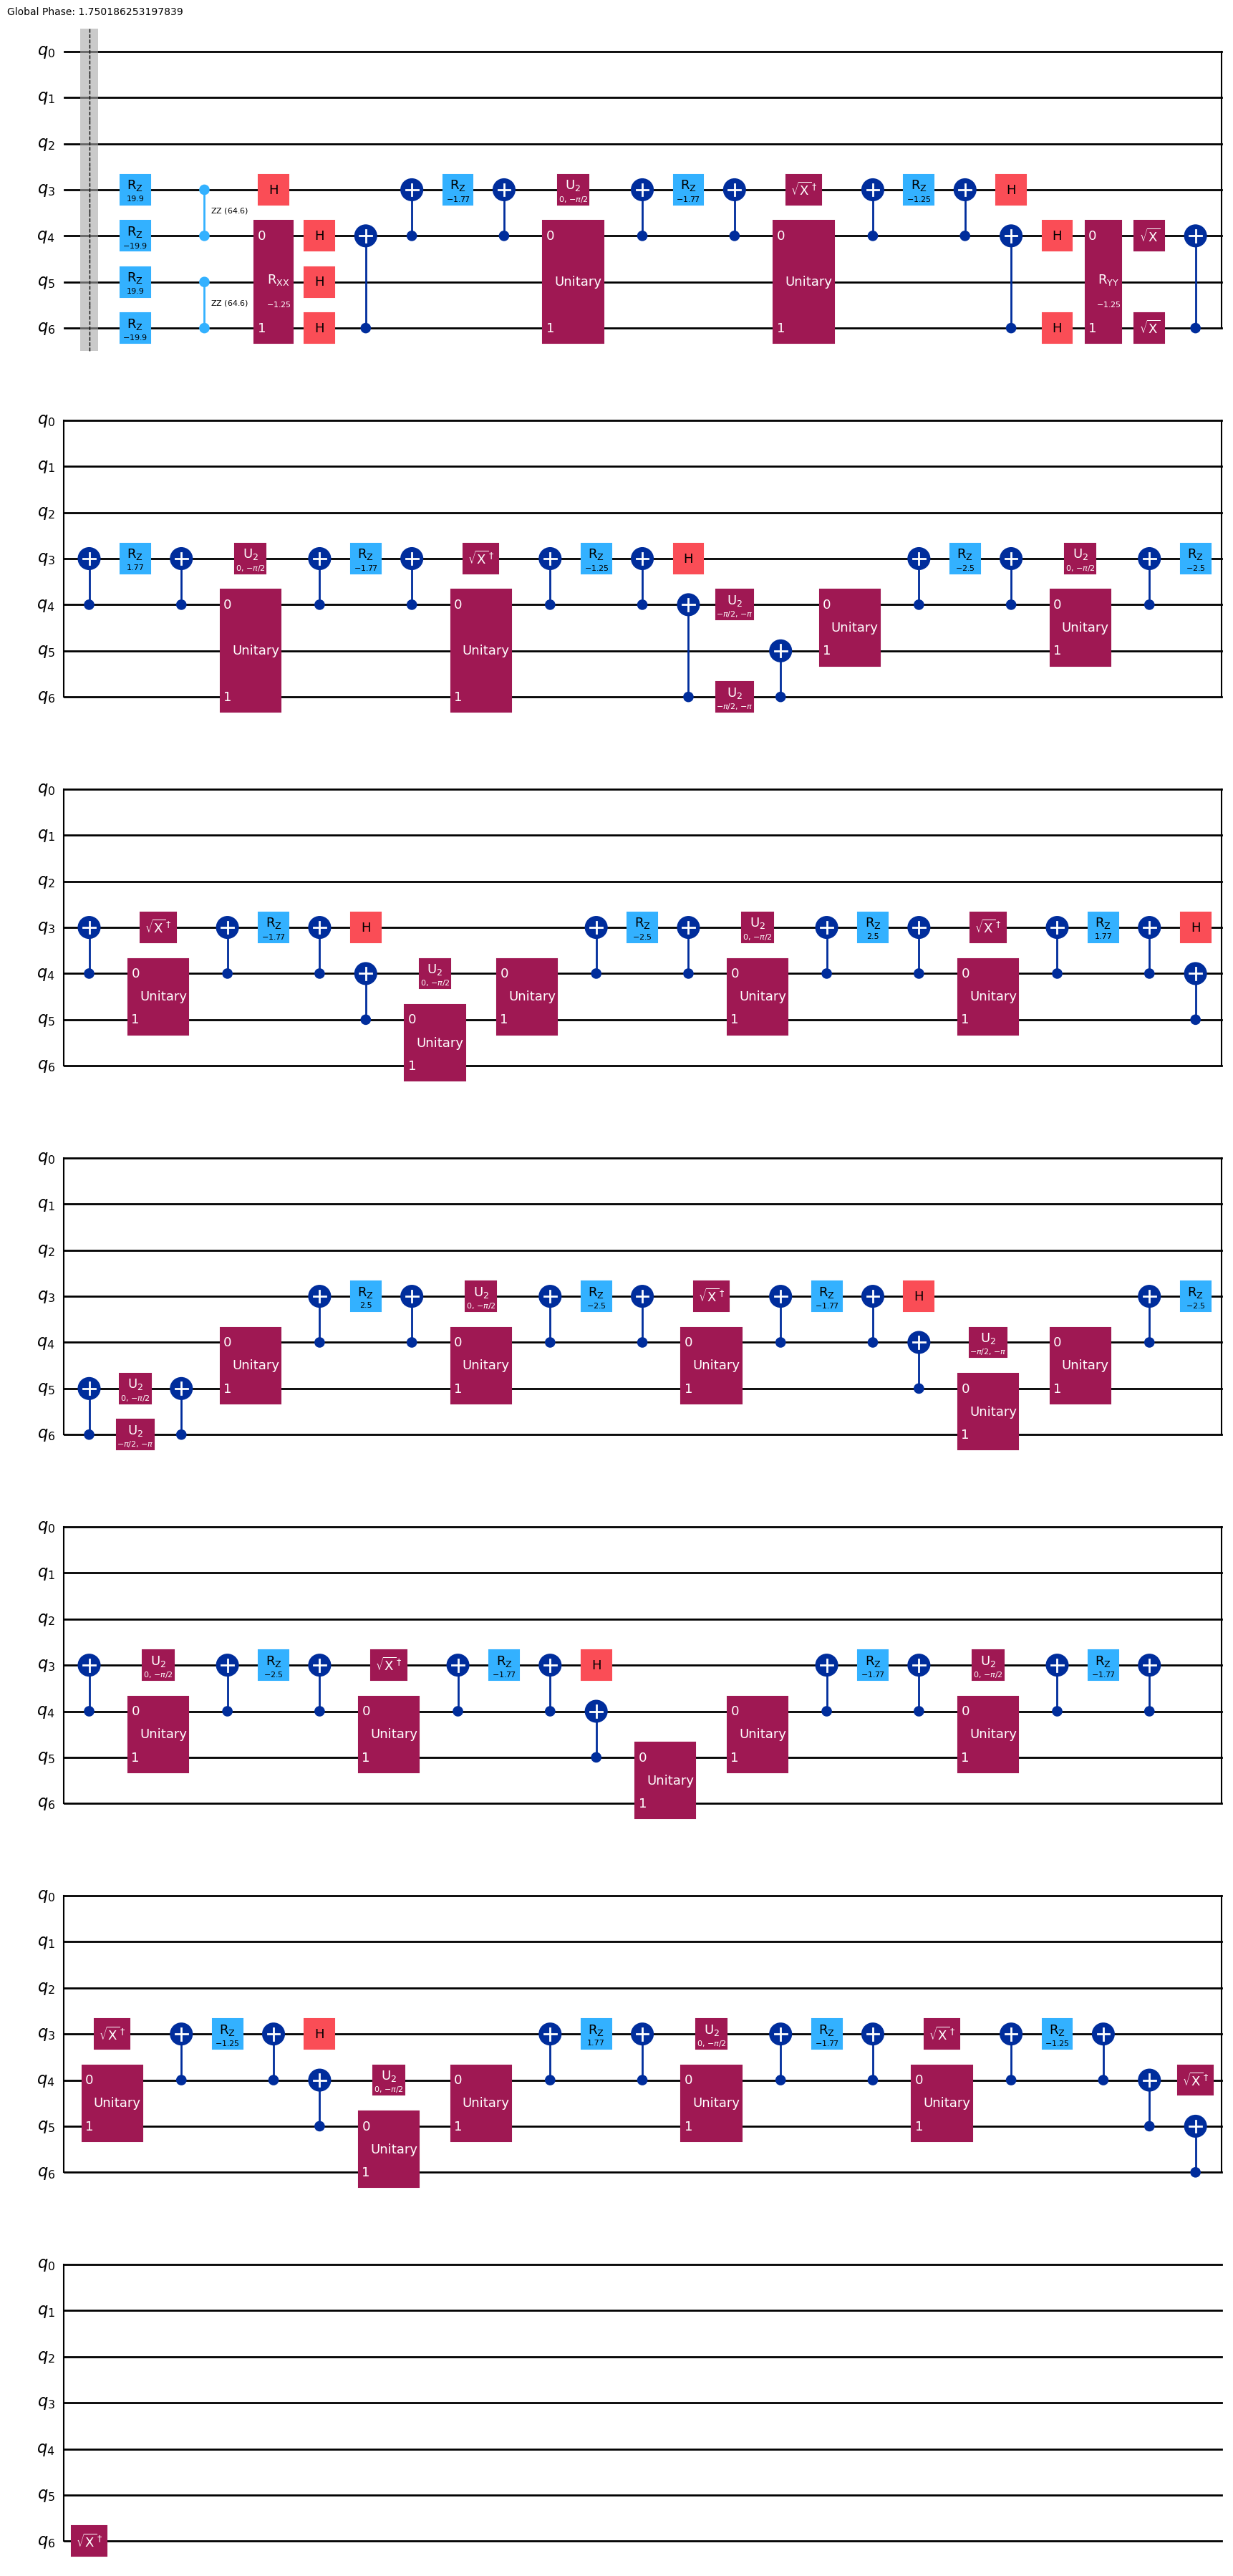

In [4]:
compiled_circuit.draw('mpl')

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit.quantum_info import Statevector, Operator, SparsePauliOp
from qiskit.circuit.library import PauliEvolutionGate
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator

# --- 1. Define System Parameters ---
# These are example values. You should use the specific values from your problem.
E_C = 1.0   # Charging energy (e.g., in GHz, or arbitrary energy units)
E_J = 10.0  # Josephson energy
hbar = 1.0  # Set hbar = 1 for simplicity in calculations (energy units are implied)

# Derived parameters
omega_1 = np.sqrt(8 * E_C * E_J) / hbar # Plasma frequency for site 1
omega_2 = np.sqrt(8 * E_C * E_J) / hbar # Plasma frequency for site 2
K_1 = E_C   # Anharmonicity for site 1 (from doc: alpha = E_C)
K_2 = E_C   # Anharmonicity for site 2
J = 0.5 * E_J # Josephson tunneling amplitude (adjust as needed, related to E_J)

# Number of qubits
num_qubits_per_site = 2 # 2 qubits for 3 bosonic levels (0, 1, 2)
num_qubits_ancilla = 1
total_qubits = 2 * num_qubits_per_site + num_qubits_ancilla # 5 qubits

# Define qubit indices for clarity (LSB...MSB for string representation):
# Site 1: qubits 0, 1 (q0=LSB of site 1, q1=MSB of site 1)
# Site 2: qubits 2, 3 (q2=LSB of site 2, q3=MSB of site 2)
# Ancilla: qubit 4

# --- 2. Helper Functions for Single Site Operators (Matrices) ---
# Maps bosonic states (0, 1, 2) to 2-qubit computational basis states (|00>, |01>, |10>)
# The unused state is |11>

def _get_site_op_matrix(op_type):
    """
    Returns the 4x4 matrix for a single site's bosonic operator.
    op_type can be 'n' (number), 'anharmonicity', 'b' (annihilation), 'b_dagger' (creation).
    Assumes Np=3 levels (0, 1, 2 bosons) mapped to |00>, |01>, |10>.
    """
    matrix = np.zeros((4, 4), dtype=complex)

    # Qubit basis mapping:
    # |00> corresponds to 0 bosons
    # |01> corresponds to 1 boson
    # |10> corresponds to 2 bosons
    # |11> is unused/forbidden

    if op_type == 'n': # Number operator n = |1><1| + 2|2><2|
        matrix[1, 1] = 1  # 1 boson state |01>
        matrix[2, 2] = 2  # 2 boson state |10>
    elif op_type == 'anharmonicity': # |2><2| (from the document's 2|2><2| for H term)
        matrix[2, 2] = 1  # Corresponds to 2 bosons state |10>
    elif op_type == 'b': # Annihilation operator b
        # b|1> = 1|0>  => matrix[index(|00>), index(|01>)] = 1
        matrix[0, 1] = 1
        # b|2> = sqrt(2)|1> => matrix[index(|01>), index(|10>)] = sqrt(2)
        matrix[1, 2] = np.sqrt(2)
    elif op_type == 'b_dagger': # Creation operator b_dagger
        # b_dagger|0> = 1|1> => matrix[index(|01>), index(|00>)] = 1
        matrix[1, 0] = 1
        # b_dagger|1> = sqrt(2)|2> => matrix[index(|10>), index(|01>)] = sqrt(2)
        matrix[2, 1] = np.sqrt(2)
    else:
        raise ValueError(f"Unknown op_type: {op_type}")
    return matrix

# Helper to expand a SparsePauliOp from a subsystem to the full system
def expand_op_to_full_system(sub_op: SparsePauliOp, sub_qubits: list, total_qubits: int):
    """
    Expands a SparsePauliOp defined on a subsystem to the full system by
    inserting 'I's on non-acting qubits.
    sub_qubits must be sorted in increasing order for correct mapping.
    """
    full_op_list = []
    
    for i in range(len(sub_op.paulis)):
        pauli_label = str(sub_op.paulis[i]) # This gives MSB...LSB string
        coeff = sub_op.coeffs[i]
        
        full_pauli_chars = ['I'] * total_qubits
        
        for k in range(len(pauli_label)):
            sub_q_idx_lsb_order = len(pauli_label) - 1 - k
            full_q_idx = sub_qubits[sub_q_idx_lsb_order]
            full_pauli_chars[full_q_idx] = pauli_label[k]
        
        full_pauli_string_lsb_msb = "".join(full_pauli_chars)
        full_op_list.append((full_pauli_string_lsb_msb, coeff))

    return SparsePauliOp.from_list(full_op_list)

# --- 3. Construct the Full Hamiltonian as SparsePauliOp ---
full_hamiltonian = SparsePauliOp('I' * total_qubits, 0) # Initialize with zero operator

# On-site energy terms (hbar*omega_i * n_i)
n_op_s_sub = SparsePauliOp.from_operator(Operator(_get_site_op_matrix('n')))
full_hamiltonian += omega_1 * expand_op_to_full_system(n_op_s_sub, [0, 1], total_qubits)
full_hamiltonian += omega_2 * expand_op_to_full_system(n_op_s_sub, [2, 3], total_qubits)

# Anharmonicity terms (-K_i * |2><2|_i)
anharm_op_s_sub = SparsePauliOp.from_operator(Operator(_get_site_op_matrix('anharmonicity')))
full_hamiltonian += -K_1 * expand_op_to_full_system(anharm_op_s_sub, [0, 1], total_qubits)
full_hamiltonian += -K_2 * expand_op_to_full_system(anharm_op_s_sub, [2, 3], total_qubits)

# Tunneling Term: $-J(\overline{b}_{1}^{\dagger}\overline{b}_{2}+\overline{b}_{2}^{\dagger}\overline{b}_{1})$
b_op_s_sub = SparsePauliOp.from_operator(Operator(_get_site_op_matrix('b')))
b_dagger_op_s_sub = SparsePauliOp.from_operator(Operator(_get_site_op_matrix('b_dagger')))

# Term 1: b_dagger_1 @ b_2
b1_dag_paulis = b_dagger_op_s_sub.paulis
b1_dag_coeffs = b_dagger_op_s_sub.coeffs
b2_paulis = b_op_s_sub.paulis
b2_coeffs = b_op_s_sub.coeffs

for i in range(len(b1_dag_paulis)):
    for j in range(len(b2_paulis)):
        pauli_label_s1 = str(b1_dag_paulis[i])
        pauli_label_s2 = str(b2_paulis[j])
        
        combined_coeff = b1_dag_coeffs[i] * b2_coeffs[j]
        
        full_pauli_chars = ['I'] * total_qubits
        
        full_pauli_chars[0] = pauli_label_s1[len(pauli_label_s1)-1] # LSB of site 1
        full_pauli_chars[1] = pauli_label_s1[len(pauli_label_s1)-2] # MSB of site 1

        full_pauli_chars[2] = pauli_label_s2[len(pauli_label_s2)-1] # LSB of site 2
        full_pauli_chars[3] = pauli_label_s2[len(pauli_label_s2)-2] # MSB of site 2
        
        combined_pauli_string_lsb_msb = "".join(full_pauli_chars)
        full_hamiltonian += SparsePauliOp(combined_pauli_string_lsb_msb, combined_coeff)

# Term 2: b_dagger_2 @ b_1 (Hermitian conjugate of the above by swapping b1dag and b2)
b2_dag_paulis = b_dagger_op_s_sub.paulis
b2_dag_coeffs = b_dagger_op_s_sub.coeffs
b1_paulis = b_op_s_sub.paulis
b1_coeffs = b_op_s_sub.coeffs

for i in range(len(b2_dag_paulis)):
    for j in range(len(b1_paulis)):
        pauli_label_s2 = str(b2_dag_paulis[i])
        pauli_label_s1 = str(b1_paulis[j])
        
        combined_coeff = b2_dag_coeffs[i] * b1_coeffs[j]
        
        full_pauli_chars = ['I'] * total_qubits
        
        full_pauli_chars[0] = pauli_label_s1[len(pauli_label_s1)-1]
        full_pauli_chars[1] = pauli_label_s1[len(pauli_label_s1)-2]

        full_pauli_chars[2] = pauli_label_s2[len(pauli_label_s2)-1]
        full_pauli_chars[3] = pauli_label_s2[len(pauli_label_s2)-2]
        
        combined_pauli_string_lsb_msb = "".join(full_pauli_chars)
        full_hamiltonian += SparsePauliOp(combined_pauli_string_lsb_msb, combined_coeff)

# Multiply the entire tunneling part by -J
full_hamiltonian *= -J

# Simplify/combine redundant terms in the Hamiltonian
full_hamiltonian = full_hamiltonian.simplify()
print("Constructed Hamiltonian (SparsePauliOp):\n", full_hamiltonian)


# --- 4. Define the Initial State ---
# The state is |1,2> for bosonic sites and |+> for ancilla
# Site 1 (1 boson): |01> for qubits [q1, q0] -> q1=0, q0=1
# Site 2 (2 bosons): |10> for qubits [q3, q2] -> q3=1, q2=0
# Ancilla 0: |0> for q4
# Ancilla 1: |1> for q4

# State |1,2,0>: qubits [q4, q3, q2, q1, q0] -> |0, 1, 0, 0, 1> in MSB...LSB
# State |1,2,1>: qubits [q4, q3, q2, q1, q0] -> |1, 1, 0, 0, 1> in MSB...LSB

# Convert these to decimal for Statevector.from_int which expects MSB...LSB
initial_state_decimal_0 = int('01001', 2) # q4=0, q3=1, q2=0, q1=0, q0=1 (MSB...LSB)
initial_state_decimal_1 = int('11001', 2) # q4=1, q3=1, q2=0, q1=0, q0=1 (MSB...LSB)

initial_statevector = Statevector.from_int(initial_state_decimal_0, dims=(2,)*total_qubits) + \
                      Statevector.from_int(initial_state_decimal_1, dims=(2,)*total_qubits)
# Corrected line for normalization
initial_statevector = initial_statevector / np.linalg.norm(initial_statevector.data)

print("\nInitial Statevector:\n", initial_statevector)


# --- 5. Perform Time Evolution and Collect Data ---
time_points = np.linspace(0, 5, 50) # Evolve from t=0 to t=5 with 50 steps

prob_ancilla_0_exact_list = []
prob_ancilla_0_circuit_list = []
prob_site1_1_boson_exact_list = []
prob_site1_1_boson_circuit_list = []

# Pre-compute Hamiltonian operator matrix
hamiltonian_operator_matrix = Operator(full_hamiltonian)
simulator = AerSimulator(method='statevector')

for t in time_points:
    # Option 1: Exact Time Evolution
    evolved_statevector_exact = initial_statevector.evolve(
        Operator(np.exp(-1j * t * hamiltonian_operator_matrix.data))
    )

    # Option 2: Circuit Evolution via PauliEvolutionGate
    circuit = QuantumCircuit(total_qubits)
    circuit.set_statevector(initial_statevector)
    evolution_gate = PauliEvolutionGate(full_hamiltonian, time=t)
    circuit.append(evolution_gate, circuit.qubits)
    
    compiled_circuit = transpile(circuit, simulator)
    job = simulator.run(compiled_circuit, shots=1)
    result = job.result()
    
    # Attempt to retrieve statevector directly from result.data
    # This is a more direct way to access results, often robust against
    # issues with get_statevector(circuit_object)
    if 'statevector' in result.data():
        circuit_evolved_statevector = result.data()['statevector']
    else:
        # Fallback if 'statevector' key is not directly present (shouldn't happen with method='statevector')
        # This error indicates a deeper issue, potentially with Qiskit installation or Aer setup.
        raise QiskitError(f"No statevector found in result.data() for time={t}. "
                          "Please ensure qiskit-aer is correctly installed and up-to-date.")


    # Analyze Results
    # Probability of finding ancilla in |0> (q4)
    prob_ancilla_0_exact = sum(p for i, p in enumerate(Statevector(evolved_statevector_exact).probabilities()) if (i >> 4) % 2 == 0)
    prob_ancilla_0_circuit = sum(p for i, p in enumerate(Statevector(circuit_evolved_statevector).probabilities()) if (i >> 4) % 2 == 0)
    prob_ancilla_0_exact_list.append(prob_ancilla_0_exact)
    prob_ancilla_0_circuit_list.append(prob_ancilla_0_circuit)

    # Probability of finding 1 boson on site 1 (qubits [q1, q0] being |01>)
    prob_site1_1_boson_exact = sum(p for i, p in enumerate(Statevector(evolved_statevector_exact).probabilities())
                                   if ((i >> 0) & 1 == 1) and ((i >> 1) & 1 == 0))
    prob_site1_1_boson_circuit = sum(p for i, p in enumerate(Statevector(circuit_evolved_statevector).probabilities())
                                    if ((i >> 0) & 1 == 1) and ((i >> 1) & 1 == 0))
    prob_site1_1_boson_exact_list.append(prob_site1_1_boson_exact)
    prob_site1_1_boson_circuit_list.append(prob_site1_1_boson_circuit)


# --- 6. Plot Results ---
plt.figure(figsize=(12, 5))

# Plot for Ancilla in |0>
plt.subplot(1, 2, 1)
plt.plot(time_points, prob_ancilla_0_exact_list, label='Exact Evolution')
plt.plot(time_points, prob_ancilla_0_circuit_list, label='Circuit Evolution (PauliEvolutionGate)', linestyle='--')
plt.title('Probability of Ancilla in $|0\\rangle$ Over Time')
plt.xlabel('Time')
plt.ylabel('Probability')
plt.legend()
plt.grid(True)

# Plot for 1 Boson on Site 1
plt.subplot(1, 2, 2)
plt.plot(time_points, prob_site1_1_boson_exact_list, label='Exact Evolution')
plt.plot(time_points, prob_site1_1_boson_circuit_list, label='Circuit Evolution (PauliEvolutionGate)', linestyle='--')
plt.title('Probability of 1 Boson on Site 1 Over Time')
plt.xlabel('Time')
plt.ylabel('Probability')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig('josephson_junction_evolution.png')
print("Plots saved to josephson_junction_evolution.png")

Constructed Hamiltonian (SparsePauliOp):
 SparsePauliOp(['IIIII', 'ZIIII', 'IZIII', 'ZZIII', 'IIZII', 'IIIZI', 'IIZZI', 'XIXII', 'XIXXI', 'XIYYI', 'XIXZI', 'YIYII', 'YIYXI', 'YIXYI', 'YIYZI', 'XXXII', 'XXXXI', 'XXYYI', 'XXXZI', 'YXYII', 'YXYXI', 'YXXYI', 'YXYZI', 'XYYII', 'XYYXI', 'XYXYI', 'XYYZI', 'YYXII', 'YYXXI', 'YYYYI', 'YYXZI', 'XZXII', 'XZXXI', 'XZYYI', 'XZXZI', 'YZYII', 'YZYXI', 'YZXYI', 'YZYZI'],
              coeffs=[-64.58203932+0.j,  -9.93033989+0.j,   9.93033989+0.j,  32.29101966+0.j,
  -9.93033989+0.j,   9.93033989+0.j,  32.29101966+0.j,  -0.625     +0.j,
  -0.88388348+0.j,  -0.88388348+0.j,  -0.625     +0.j,  -0.625     +0.j,
   0.88388348+0.j,  -0.88388348+0.j,  -0.625     +0.j,  -0.88388348+0.j,
  -1.25      +0.j,  -1.25      +0.j,  -0.88388348+0.j,   0.88388348+0.j,
  -1.25      +0.j,   1.25      +0.j,   0.88388348+0.j,  -0.88388348+0.j,
   1.25      +0.j,  -1.25      +0.j,  -0.88388348+0.j,  -0.88388348+0.j,
  -1.25      +0.j,  -1.25      +0.j,  -0.88388348+0.j,  -0.

NameError: name 'QiskitError' is not defined